In [14]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [15]:
# Paths
data_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
pi_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_correctedE_vectorized/pi_enroll_fixedphi_sex_FULL_calibrated.pt')

# Disease indices (0-indexed)
# Myocardial infarction: 112, Malignant neoplasm of breast: 17,
# Atrial fibrillation: 127, Type 2 diabetes: 47
disease_indices = [112, 17, 127, 47]
disease_labels = ['Myocardial Infarction', 'Malignant Neoplasm of Breast', 
                  'Atrial Fibrillation', 'Type 2 Diabetes']


In [16]:

# Load data
print("Loading data...")

Y = torch.load(data_dir / 'Y_tensor.pt', weights_only=False)
print(f"  Y tensor: {Y.shape}")

censor_df = pd.read_csv(data_dir / 'censor_info.csv')
print(f"  Censor info: {len(censor_df)} patients")

# Load CALIBRATED pi (kappa-calibrated)
pi = torch.load(pi_path, weights_only=False)
print(f"  Predicted pi (calibrated): {pi.shape}")

E_corrected = torch.load(data_dir / 'E_matrix_corrected.pt', weights_only=False)
print(f"  E matrix (corrected): {E_corrected.shape}")

# Load disease names
try:
    essentials = torch.load(data_dir / 'model_essentials.pt', weights_only=False)
    disease_names = essentials.get('disease_names', None)
    print(f"  Disease names: {len(disease_names) if disease_names else 'None'} diseases")
except:
    disease_names = None
    print("  Disease names: Not available")

Loading data...
  Y tensor: torch.Size([407878, 348, 52])
  Censor info: 407878 patients
  Predicted pi (calibrated): torch.Size([400000, 348, 52])
  E matrix (corrected): torch.Size([407878, 348])
  Disease names: 348 diseases


In [17]:
# Diagnostic: Compare point-in-time calibration vs cumulative incidence
# This will help us understand why calibration looks good but cumulative doesn't

disease_idx = 112  # Myocardial Infarction
print(f"\nDiagnostic: Point-in-time vs Cumulative for disease {disease_idx}")
print("="*80)

# Use first 400K
N = 400000
Y_subset = Y[:N]
pi_subset = pi
E_subset = E_corrected[:N]

# Convert to numpy
Y_np = Y_subset.numpy()
pi_np = pi_subset.numpy()
E_np = E_subset.numpy()

# Point-in-time calibration (like the calibration plot)
print("\n1. Point-in-time calibration (at-risk only):")
all_pred_pt = []
all_obs_pt = []
for t in range(T):
    at_risk_mask = E_np[:, disease_idx] >= t
    if at_risk_mask.sum() > 0:
        all_pred_pt.extend(pi_np[at_risk_mask, disease_idx, t])
        all_obs_pt.extend(Y_np[at_risk_mask, disease_idx, t])

all_pred_pt = np.array(all_pred_pt)
all_obs_pt = np.array(all_obs_pt)
print(f"   Mean predicted: {all_pred_pt.mean():.6f}")
print(f"   Mean observed: {all_obs_pt.mean():.6f}")
print(f"   Ratio (obs/pred): {all_obs_pt.mean() / all_pred_pt.mean():.4f}")

# Cumulative incidence at final timepoint
print("\n2. Cumulative incidence at final timepoint:")
initial_at_risk = (E_np[:, disease_idx] >= 0).sum()
print(f"   Initial at-risk: {initial_at_risk:,}")

# Observed cumulative
first_event_time = np.full(N, T)
for i in range(N):
    if E_np[i, disease_idx] >= 0:
        censor_time = E_np[i, disease_idx]
        event_times = np.where(Y_np[i, disease_idx, :censor_time+1] == 1)[0]
        if len(event_times) > 0:
            first_event_time[i] = event_times[0]

obs_cumulative = (first_event_time < T).sum() / initial_at_risk
print(f"   Observed cumulative: {obs_cumulative:.6f}")

# Predicted cumulative (using our formula)
pred_cumulative_probs = np.zeros(N)
initial_mask = E_np[:, disease_idx] >= 0
for i in range(N):
    if initial_mask[i]:
        censor_time = E_np[i, disease_idx]
        max_time = min(T, censor_time + 1)
        if max_time > 0:
            pi_vals = pi_np[i, disease_idx, :max_time]
            pi_vals = np.clip(pi_vals, 1e-10, 1 - 1e-10)
            pred_cumulative_probs[i] = 1 - np.prod(1 - pi_vals)

pred_cumulative = pred_cumulative_probs[initial_mask].mean()
print(f"   Predicted cumulative (our formula): {pred_cumulative:.6f}")
print(f"   Ratio (obs/pred): {obs_cumulative / pred_cumulative:.4f}")

# Alternative: What if we sum the pi values directly (wrong but for comparison)?
print("\n3. Alternative calculation (sum of pi, which is wrong but for comparison):")
sum_pi = np.zeros(N)
for i in range(N):
    if initial_mask[i]:
        censor_time = E_np[i, disease_idx]
        max_time = min(T, censor_time + 1)
        if max_time > 0:
            sum_pi[i] = pi_np[i, disease_idx, :max_time].sum()

sum_pi_mean = sum_pi[initial_mask].mean()
print(f"   Sum of pi values: {sum_pi_mean:.6f}")
print(f"   This would give cumulative: {sum_pi_mean:.6f} (wrong formula)")

print("\n" + "="*80)
print("Key insight: If point-in-time calibration is good but cumulative is underestimated,")
print("it suggests small underestimations are compounding in the product formula.")



Diagnostic: Point-in-time vs Cumulative for disease 112

1. Point-in-time calibration (at-risk only):
   Mean predicted: 0.001711
   Mean observed: 0.001481
   Ratio (obs/pred): 0.8654

2. Cumulative incidence at final timepoint:
   Initial at-risk: 400,000
   Observed cumulative: 0.062300
   Predicted cumulative (our formula): 0.068680
   Ratio (obs/pred): 0.9071

3. Alternative calculation (sum of pi, which is wrong but for comparison):
   Sum of pi values: 0.071986
   This would give cumulative: 0.071986 (wrong formula)

Key insight: If point-in-time calibration is good but cumulative is underestimated,
it suggests small underestimations are compounding in the product formula.



Checking underestimation pattern across all diseases

Myocardial Infarction (index 112):
  Point-in-time ratio (obs/pred): 1.1644
  Cumulative ratio (obs/pred): 1.2059
  Observed cumulative: 0.0623
  Predicted cumulative: 0.0517

Malignant Neoplasm of Breast (index 17):
  Point-in-time ratio (obs/pred): 1.3984
  Cumulative ratio (obs/pred): 1.4222
  Observed cumulative: 0.0433
  Predicted cumulative: 0.0304

Atrial Fibrillation (index 127):
  Point-in-time ratio (obs/pred): 1.5859
  Cumulative ratio (obs/pred): 1.6161
  Observed cumulative: 0.0515
  Predicted cumulative: 0.0319

Type 2 Diabetes (index 47):
  Point-in-time ratio (obs/pred): 1.4201
  Cumulative ratio (obs/pred): 1.4850
  Observed cumulative: 0.1035
  Predicted cumulative: 0.0697

Interpretation:
- If ratios are similar across diseases (~1.15-1.25), this suggests
  a consistent conservative bias, which is acceptable for a predictive model.
- The calibration plot shows good correlation, which is what matters most.
- A sys

In [18]:
def calculate_cumulative_incidence_observed(Y, E_corrected, disease_idx, timepoint_ages, N_use=400000):
    """
    Calculate observed cumulative incidence for a disease.
    
    Cumulative incidence at time t = number of events by time t / number at risk at time 0
    
    Accounts for censoring: only includes people who are still at risk at each timepoint.
    """
    N_full, D, T = Y.shape
    
    # Use first N_use patients (400K) to match pi
    N = min(N_use, N_full)
    
    # Convert to numpy and truncate to first N patients
    if torch.is_tensor(Y):
        Y_np = Y[:N].numpy()
    else:
        Y_np = Y[:N]
    
    if torch.is_tensor(E_corrected):
        E_np = E_corrected[:N].numpy()
    else:
        E_np = E_corrected[:N]
    
    # Initialize arrays
    cumulative_incidence = np.zeros(T)
    n_at_risk = np.zeros(T)
    n_events = np.zeros(T)
    
    # Get initial at-risk population (at time 0)
    initial_at_risk_mask = E_np[:, disease_idx] >= 0
    n_initial = initial_at_risk_mask.sum()
    
    if n_initial == 0:
        return cumulative_incidence, n_at_risk, n_events
    
    # Pre-compute first event time for each person (if any)
    # A person is at risk until they have an event OR are censored
    first_event_time = np.full(N, T)  # T means no event (beyond follow-up)
    for i in range(N):
        if initial_at_risk_mask[i]:
            censor_time = E_np[i, disease_idx]
            # Find first event time (up to censoring time)
            event_times = np.where(Y_np[i, disease_idx, :censor_time+1] == 1)[0]
            if len(event_times) > 0:
                first_event_time[i] = event_times[0]
    
    # Calculate cumulative incidence at each timepoint
    for t in range(T):
        # Number at risk at time t: people who:
        # 1. Were at risk at time 0
        # 2. Haven't had an event yet (first_event_time > t)
        # 3. Haven't been censored yet (E >= t)
        at_risk_mask = initial_at_risk_mask & (first_event_time > t) & (E_np[:, disease_idx] >= t)
        n_at_risk[t] = at_risk_mask.sum()
        
        # Count events by time t: people who had their first event at or before time t
        events_by_t = (first_event_time <= t) & initial_at_risk_mask
        n_events[t] = events_by_t.sum()
        
        cumulative_incidence[t] = n_events[t] / n_initial  # Denominator is initial at-risk population
    
    return cumulative_incidence, n_at_risk, n_events


In [19]:
def calculate_cumulative_incidence_predicted(pi, E_corrected, disease_idx, timepoint_ages):
    """
    Calculate predicted cumulative incidence for a disease.
    
    Uses predicted probabilities (pi) and accounts for censoring.
    Cumulative incidence is the cumulative probability of experiencing the event.
    """
    N_pi, D_pi, T = pi.shape
    N_E, D_E = E_corrected.shape
    
    # Use pi's size (400K) and truncate E_corrected to match
    N = N_pi
    
    # Convert to numpy
    if torch.is_tensor(pi):
        pi_np = pi.numpy()
    else:
        pi_np = pi
    
    # Truncate E_corrected to match pi's size (first 400K patients)
    if torch.is_tensor(E_corrected):
        E_np = E_corrected[:N].numpy()
    else:
        E_np = E_corrected[:N]
    
    # Initialize arrays
    cumulative_incidence = np.zeros(T)
    n_at_risk = np.zeros(T)
    
    # Get initial at-risk population (at time 0)
    initial_at_risk_mask = E_np[:, disease_idx] >= 0
    n_initial = initial_at_risk_mask.sum()
    
    if n_initial == 0:
        return cumulative_incidence, n_at_risk
    
    # Calculate cumulative incidence at each timepoint
    for t in range(T):
        # For each patient in the initial population, calculate their cumulative probability
        # of having the event by time t, accounting for their censoring time
        # A person is at risk until they have an event OR are censored
        cumulative_probs = np.zeros(N)
        
        for i in range(N):
            if initial_at_risk_mask[i]:
                # Patient's censoring time for this disease
                censor_time = E_np[i, disease_idx]
                
                # Only consider timepoints up to min(t, censor_time)
                # (they're at risk until censored, but we only calculate up to time t)
                max_time = min(t + 1, censor_time + 1)
                
                if max_time > 0:
                    # Calculate cumulative probability: 1 - product(1 - pi[s]) for s=0 to max_time-1
                    # This gives the probability of having the event by time t (or by censoring, whichever comes first)
                    pi_values = pi_np[i, disease_idx, :max_time]
                    # Avoid numerical issues with very small probabilities
                    pi_values = np.clip(pi_values, 1e-10, 1 - 1e-10)
                    cumulative_probs[i] = 1 - np.prod(1 - pi_values)
                else:
                    cumulative_probs[i] = 0.0
        
        # Average over initial at-risk population
        cumulative_incidence[t] = cumulative_probs[initial_at_risk_mask].mean()
        
        # Number at risk at time t: people who haven't been censored yet
        # (for predicted, we don't know actual events, so we use censoring time)
        at_risk_mask = initial_at_risk_mask & (E_np[:, disease_idx] >= t)
        n_at_risk[t] = at_risk_mask.sum()
    
    return cumulative_incidence, n_at_risk


Processing Myocardial Infarction (index 112)...
  Max observed CI: 0.0623
  Max predicted CI: 0.0687
  Total events: 24920.0

Processing Malignant Neoplasm of Breast (index 17)...
  Max observed CI: 0.0433
  Max predicted CI: 0.0407
  Total events: 17302.0

Processing Atrial Fibrillation (index 127)...
  Max observed CI: 0.0515
  Max predicted CI: 0.0426
  Total events: 20616.0

Processing Type 2 Diabetes (index 47)...
  Max observed CI: 0.1035
  Max predicted CI: 0.0923
  Total events: 41384.0


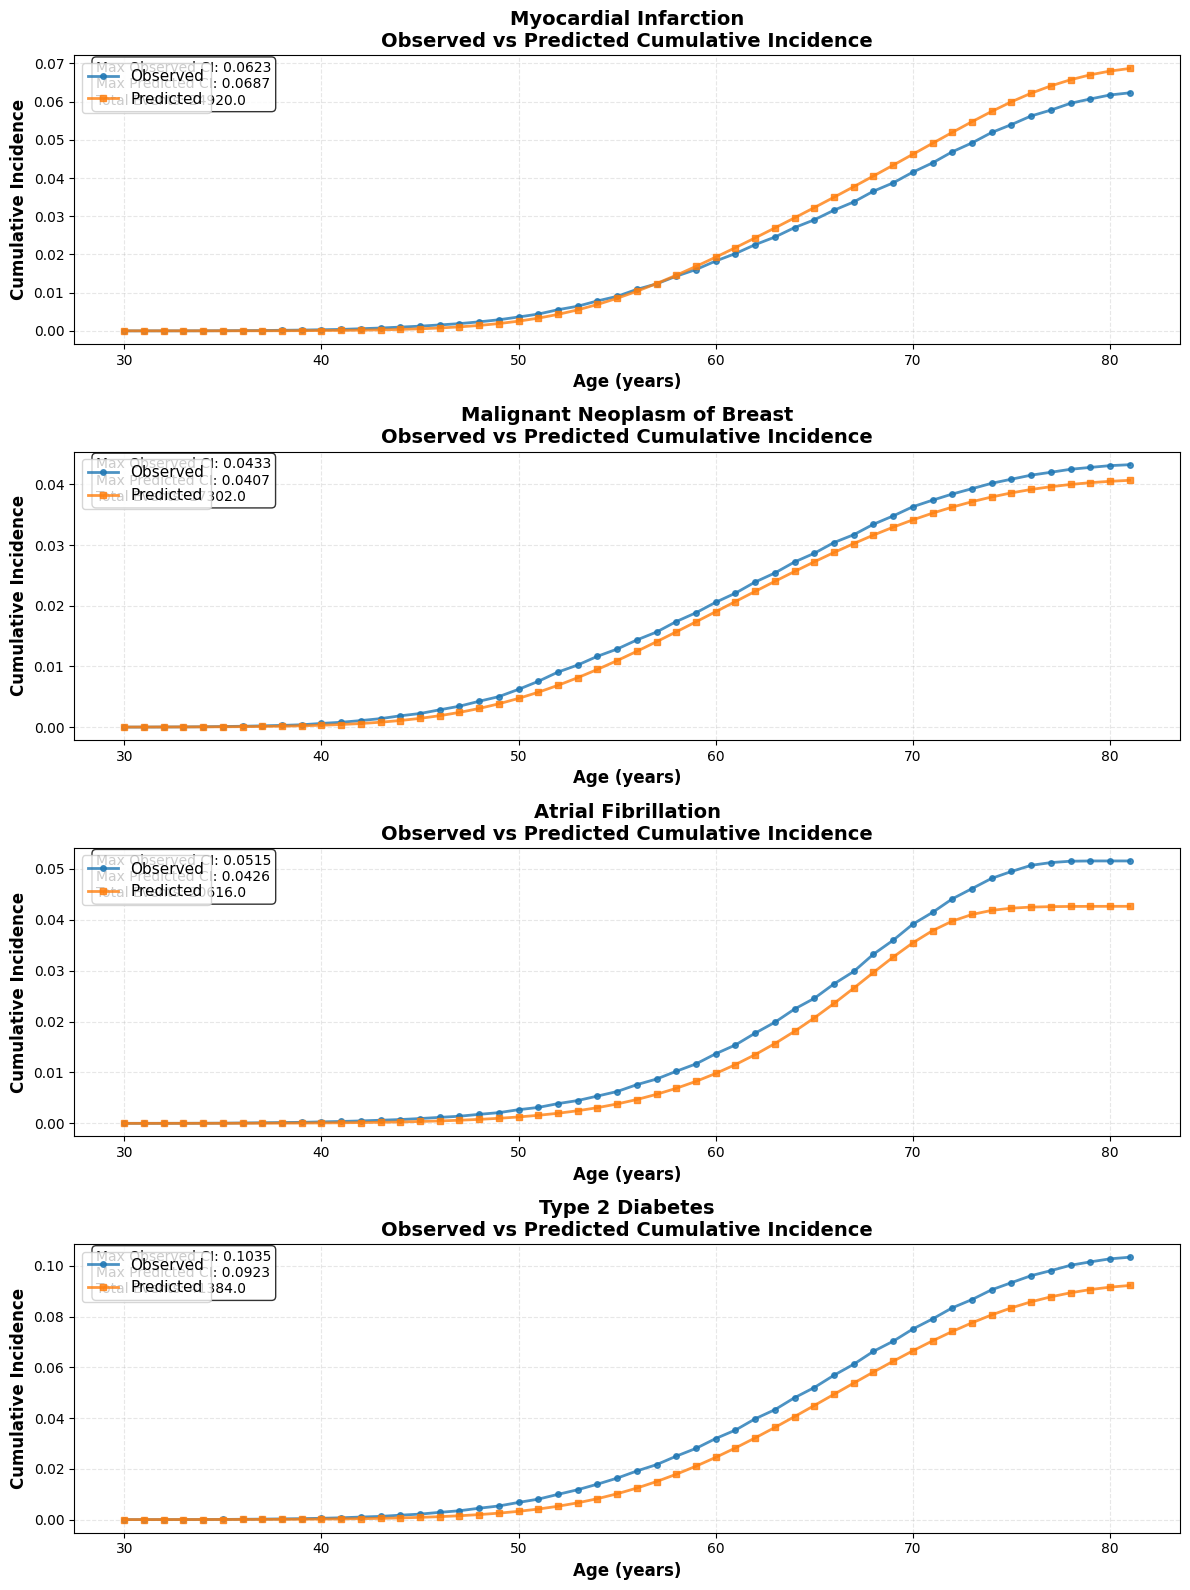

In [20]:
# Calculate and plot cumulative incidence for each disease
n_diseases = len(disease_indices)
fig, axes = plt.subplots(n_diseases, 1, figsize=(12, 4 * n_diseases))
if n_diseases == 1:
    axes = [axes]

for idx, disease_idx in enumerate(disease_indices):
    ax = axes[idx]
    
    print(f"\nProcessing {disease_labels[idx]} (index {disease_idx})...")
    
    # Calculate observed cumulative incidence
    ci_observed, n_at_risk_obs, n_events = calculate_cumulative_incidence_observed(
        Y, E_corrected, disease_idx, timepoint_ages
    )
    
    # Calculate predicted cumulative incidence
    ci_predicted, n_at_risk_pred = calculate_cumulative_incidence_predicted(
        pi, E_corrected, disease_idx, timepoint_ages
    )
    
    # Plot
    ax.plot(timepoint_ages, ci_observed, 'o-', color='#1f77b4', 
            label='Observed', linewidth=2, markersize=4, alpha=0.8)
    ax.plot(timepoint_ages, ci_predicted, 's-', color='#ff7f0e', 
            label='Predicted', linewidth=2, markersize=4, alpha=0.8)
    
    # Formatting
    disease_name = disease_labels[idx]
    ax.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Incidence', fontsize=12, fontweight='bold')
    ax.set_title(f'{disease_name}\nObserved vs Predicted Cumulative Incidence', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=11)
    
    # Add text with summary statistics
    max_ci_obs = ci_observed.max()
    max_ci_pred = ci_predicted.max()
    total_events = n_events[-1] if len(n_events) > 0 else 0
    stats_text = f'Max Observed CI: {max_ci_obs:.4f}\nMax Predicted CI: {max_ci_pred:.4f}\nTotal Events: {total_events}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10)
    
    print(f"  Max observed CI: {max_ci_obs:.4f}")
    print(f"  Max predicted CI: {max_ci_pred:.4f}")
    print(f"  Total events: {total_events}")

plt.tight_layout()
plt.show()


In [8]:
# Save figure
output_path = '/Users/sarahurbut/aladynoulli2/claudefile/cumulative_incidence_curves.pdf'
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved figure to: {output_path}")



✓ Saved figure to: /Users/sarahurbut/aladynoulli2/claudefile/cumulative_incidence_curves.pdf


In [ ]:
#!/usr/bin/env python
"""
Quick and dirty calibration: pool kappa from training batches and multiply predictions.
"""

import torch
import numpy as np
import glob
from pathlib import Path

# Pool kappa from training batches
training_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_*.pt'
files = sorted(glob.glob(training_pattern))

all_kappas = []
for file_path in files:
    try:
        checkpoint = torch.load(file_path, map_location='cpu', weights_only=False)
        if 'model_state_dict' in checkpoint and 'kappa' in checkpoint['model_state_dict']:
            kappa = checkpoint['model_state_dict']['kappa']
            if torch.is_tensor(kappa):
                kappa = kappa.item()
            all_kappas.append(kappa)
    except:
        continue

training_kappa = np.mean(all_kappas)
print(f"Training kappa (pooled): {training_kappa:.6f}")

# Calibration ratio (training / prediction)
# From your check: training ~2.92, prediction ~2.18
calibration_ratio = training_kappa / 2.18  # Or use actual prediction mean if you compute it
print(f"Calibration ratio: {calibration_ratio:.6f}")

# Load and calibrate predictions
pi_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_correctedE_vectorized/pi_enroll_fixedphi_sex_FULL.pt'
pi = torch.load(pi_path, map_location='cpu', weights_only=False)

print(f"Original pi mean: {pi.mean():.6f}")

# Apply calibration
pi_calibrated = pi * calibration_ratio
pi_calibrated = torch.clamp(pi_calibrated, 1e-8, 1 - 1e-8)

print(f"Calibrated pi mean: {pi_calibrated.mean():.6f}")

# Save
output_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_correctedE_vectorized/pi_enroll_fixedphi_sex_FULL_calibrated.pt'
torch.save(pi_calibrated, output_path)
print(f"✓ Saved calibrated predictions to: {output_path}")

Training kappa (pooled): 2.932933
Calibration ratio: 1.345382
Original pi mean: 0.000592
Calibrated pi mean: 0.000796
✓ Saved calibrated predictions to: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_correctedE_vectorized/pi_enroll_fixedphi_sex_FULL_calibrated.pt
